In [66]:
%pip install matplotlib tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [67]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [68]:
tf.keras.backend.clear_session()

In [172]:
IMG_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [173]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("./PlantVillage/potato",shuffle=True,image_size=(IMG_SIZE,IMG_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [174]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

we have 32 images per batch, with dimensiones of 256 * 256 with 3 channels (RGB)

The second array is a numerical representation of the labels in each image of the first batch taken.

In [175]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 1 1 0 1 1 2 0 0 0 1 2 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0]


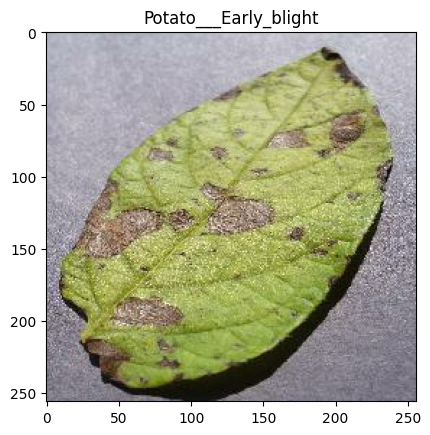

In [176]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(
        image_batch[0].numpy().astype("uint8")
    )
    plt.title(
        class_names[label_batch[0]],
    )
    plt.show()

In [74]:
len(dataset)

68

In [177]:
train_size = int(0.8 * len(dataset))
validation_size,test_size = int(0.1 * len(dataset)),int(0.1 * len(dataset))

A python function to split the data into training and validation sets using the take and skip tensorflow API.

In [179]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000,seed=42):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=seed)
    
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [77]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset,train_split=0.8,val_split=0.1,test_split=0.1)

## Setting the tensorflow data pipeline

In [180]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [181]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [182]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),])

In [183]:
input_shape = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
model = models.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])
model.build(input_shape=input_shape)

In [184]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_26 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [185]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy','mse','mae'])

In [186]:
history = model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=validation_ds)

Epoch 1/50


/Users/atorres/.local/share/virtualenvs/potato-disease-classification-sKHmlaDb-python/lib/python3.11/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 [==============================] - 33s 587ms/step - loss: 0.9127 - accuracy: 0.4765 - mse: 0.4893 - mae: 0.5814 - val_loss: 0.9119 - val_accuracy: 0.4062 - val_mse: 0.4528 - val_mae: 0.5608
Epoch 2/50
54/54 [==============================] - 30s 557ms/step - loss: 0.7058 - accuracy: 0.6555 - mse: 0.5306 - mae: 0.5814 - val_loss: 0.7224 - val_accuracy: 0.6042 - val_mse: 0.5418 - val_mae: 0.5608
Epoch 3/50
54/54 [==============================] - 29s 535ms/step - loss: 0.5459 - accuracy: 0.7805 - mse: 0.5627 - mae: 0.5814 - val_loss: 0.4646 - val_accuracy: 0.7917 - val_mse: 0.5502 - val_mae: 0.5608
Epoch 4/50
54/54 [==============================] - 29s 538ms/step - loss: 0.4142 - accuracy: 0.8263 - mse: 0.5914 - mae: 0.5814 - val_loss: 0.4432 - val_accuracy: 0.8125 - val_mse: 0.5764 - val_mae: 0.5608
Epoch 5/50
54/54 [==============================] - 28s 527ms/step - loss: 0.3348 - accuracy: 0.8715 - mse: 0.6068 - mae: 0.5814 - val_loss: 0.3821 - val_accuracy: 0.8281 - val_mse: 0

In [187]:
scores = model.evaluate(test_ds, verbose=1)

8/8 [==============================] - 2s 186ms/step - loss: 0.0459 - accuracy: 0.9883 - mse: 0.6129 - mae: 0.5495


In [188]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0, 0.5, 'loss')

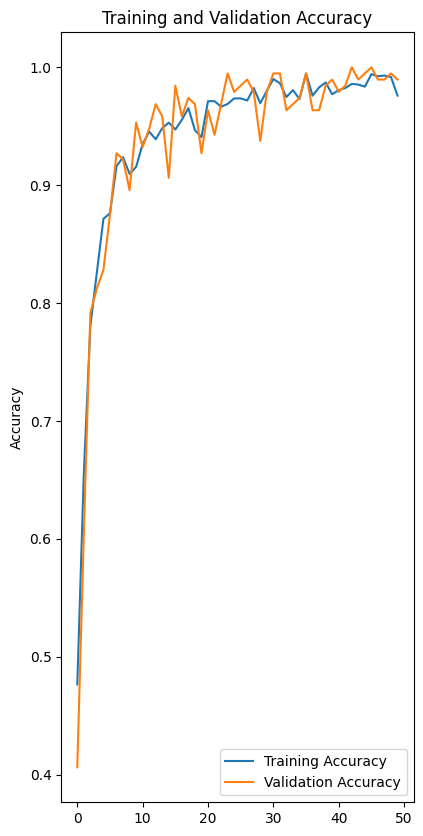

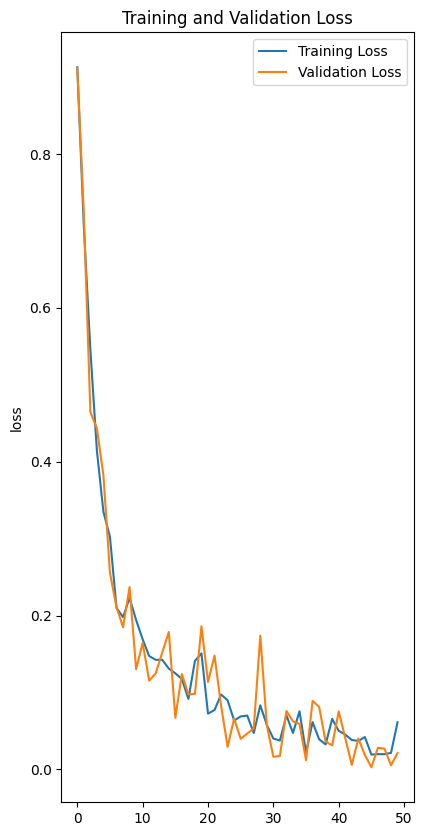

In [189]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1 )
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')

1/1 [==============================] - 0s 181ms/step
With an accuracy of 99.96%


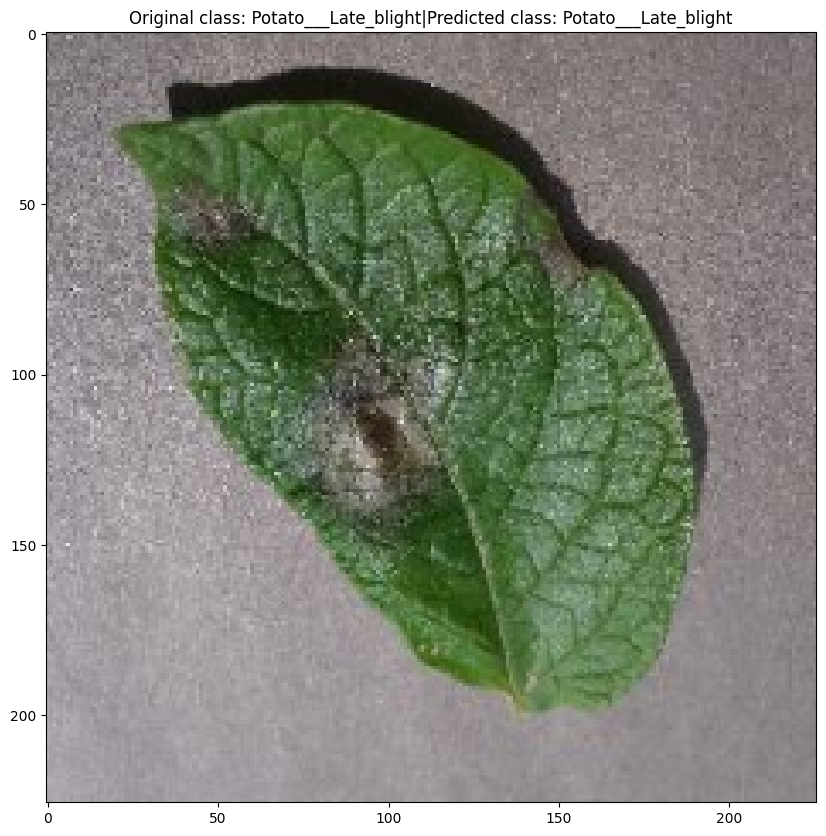

In [190]:
for image_batch,label_batch in test_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image_batch[0]
  prediction = model.predict(image_batch)
  plt.imshow(first_image.numpy().astype("uint8"))
  plt.title(f"Original class: {class_names[label_batch[0]]}|Predicted class: {class_names[prediction[0].argmax()]}")
  print(f"With an accuracy of {round(model.predict(image_batch)[0].max()*100,2)}%")

In [191]:
MODEL_VERSION="1"
model.save(f'./models/{MODEL_VERSION}')

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets


We will now compare this architecture against two other models, we will visualize the effect of dat augmentation been removed from the pipeline and then a completely different architecture.

In [140]:
original_model = tf.keras.models.load_model(f'./models/{MODEL_VERSION}')

no_da_model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
no_da_model.build(input_shape=input_shape)

model_2 = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')])

model_2.build(input_shape=input_shape)

In [141]:
no_da_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy','mse','mae'])
model_2.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy','mse','mae'])

In [142]:
no_da_model.summary()
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 226, 226, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (32, 224, 224, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPooli  (32, 112, 112, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (32, 110, 110, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (32, 55, 55, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (32, 53, 53, 64)         

Ensuring that each model is trained on the same data and same randomness

In [144]:
original_history = history
no_da_history = no_da_model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=validation_ds)
model_2_history = model_2.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,validation_data=validation_ds) 

Epoch 1/50
54/54 [==============================] - 22s 406ms/step - loss: 7.0833e-06 - accuracy: 1.0000 - mse: 0.6753 - mae: 0.5814 - val_loss: 0.0137 - val_accuracy: 0.9948 - val_mse: 0.7142 - val_mae: 0.6042
Epoch 2/50
54/54 [==============================] - 24s 453ms/step - loss: 6.4691e-06 - accuracy: 1.0000 - mse: 0.6753 - mae: 0.5814 - val_loss: 0.0150 - val_accuracy: 0.9948 - val_mse: 0.7141 - val_mae: 0.6042
Epoch 3/50
54/54 [==============================] - 23s 430ms/step - loss: 5.8534e-06 - accuracy: 1.0000 - mse: 0.6753 - mae: 0.5814 - val_loss: 0.0154 - val_accuracy: 0.9948 - val_mse: 0.7140 - val_mae: 0.6042
Epoch 4/50
54/54 [==============================] - 23s 424ms/step - loss: 5.5137e-06 - accuracy: 1.0000 - mse: 0.6753 - mae: 0.5814 - val_loss: 0.0132 - val_accuracy: 0.9948 - val_mse: 0.7140 - val_mae: 0.6042
Epoch 5/50
54/54 [==============================] - 21s 386ms/step - loss: 5.0205e-06 - accuracy: 1.0000 - mse: 0.6753 - mae: 0.5814 - val_loss: 0.0120 - va

In [145]:
no_da_model.save(f'./models/{MODEL_VERSION}_no_da')
model_2.save(f'./models/{MODEL_VERSION}_model_2')

INFO:tensorflow:Assets written to: ./models/1.0.0_no_da/assets


INFO:tensorflow:Assets written to: ./models/1.0.0_no_da/assets


INFO:tensorflow:Assets written to: ./models/1.0.0_model_2/assets


INFO:tensorflow:Assets written to: ./models/1.0.0_model_2/assets


In [ ]:
original_scores = scores
no_da_scores = no_da_model.evaluate(test_ds, verbose=1)
model_2_scores = model_2.evaluate(test_ds, verbose=1)

In [170]:
def plot_metrics(acc,val_acc,loss,val_loss,title):
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1 )
  plt.plot(range(EPOCHS),acc, label='Training Accuracy')
  plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title(f'Training and Validation Accuracy on {title}')
  plt.ylabel('Accuracy')

  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 2)
  plt.plot(range(EPOCHS),loss, label='Training Loss')
  plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title(f'Training and Validation Loss on {title}')
  plt.ylabel('loss')

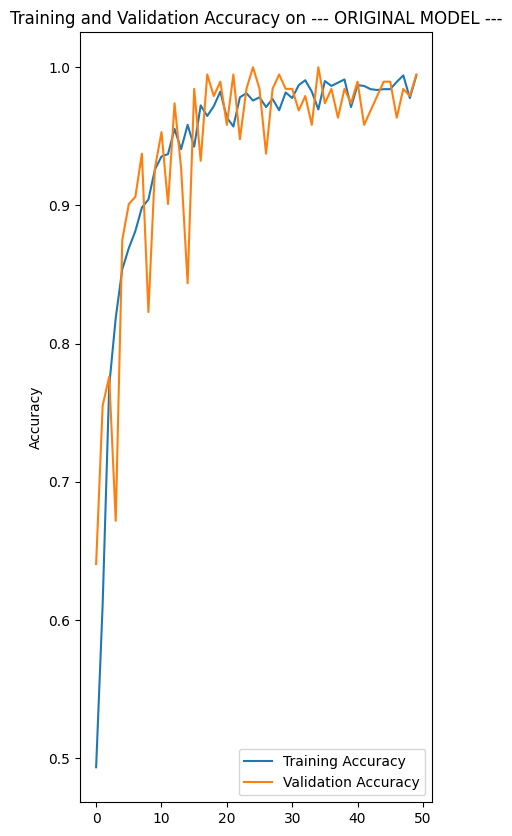

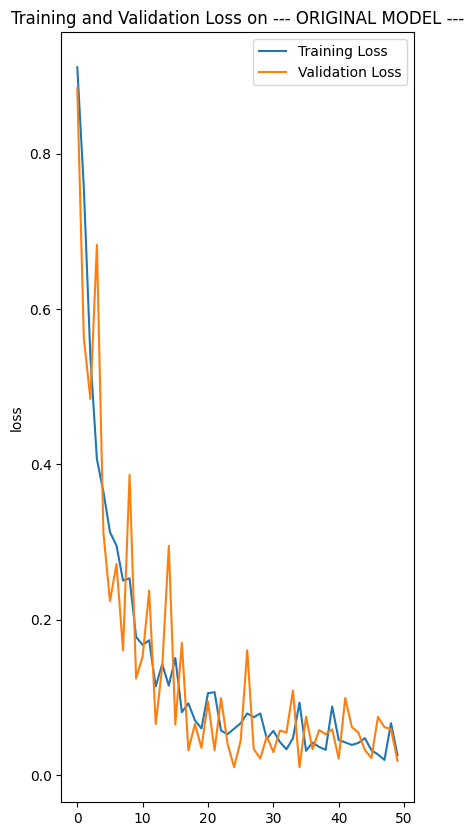

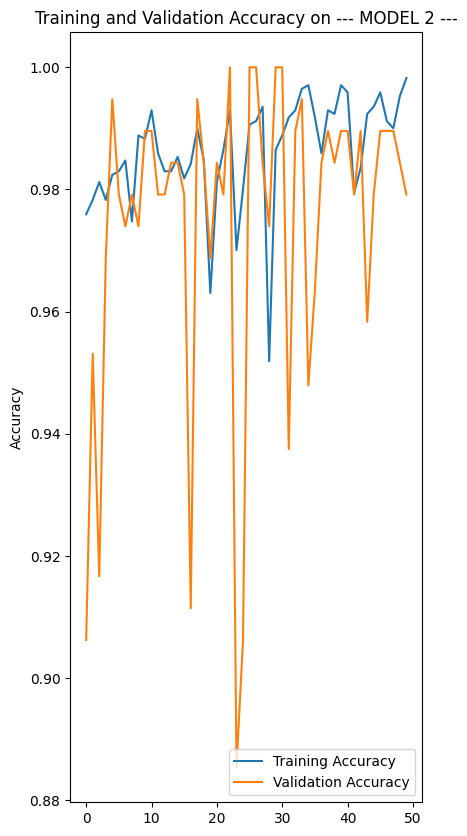

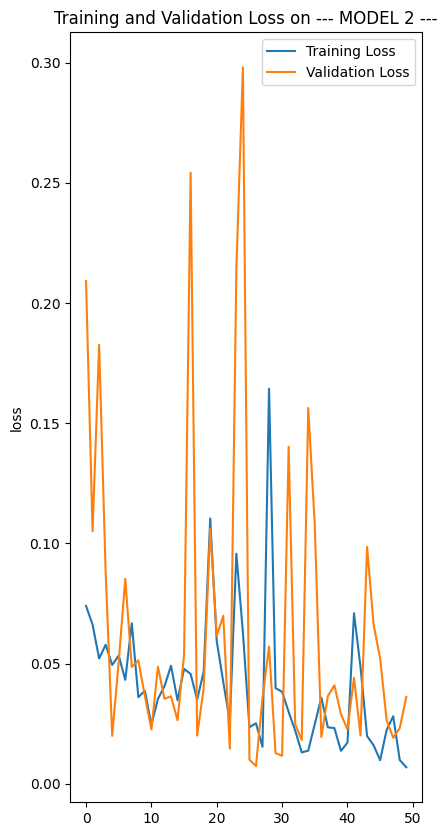

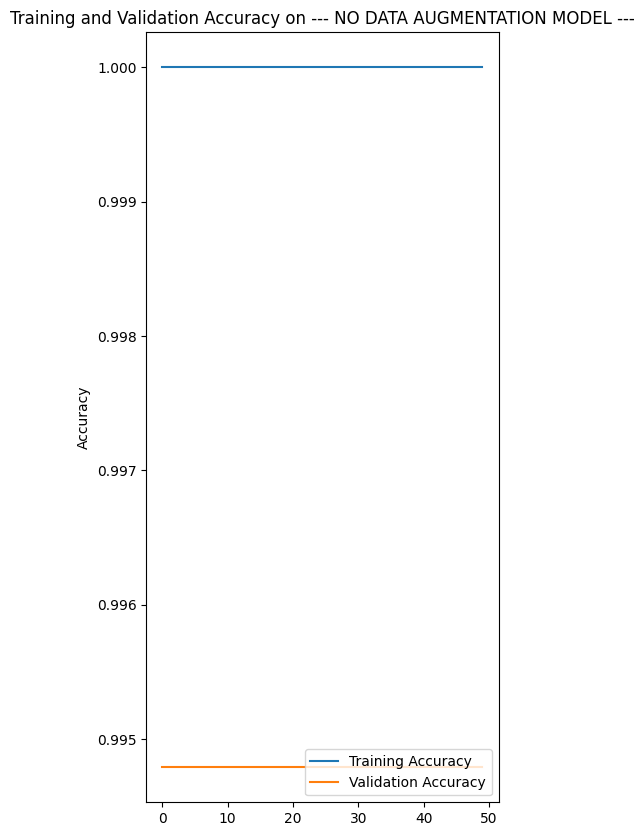

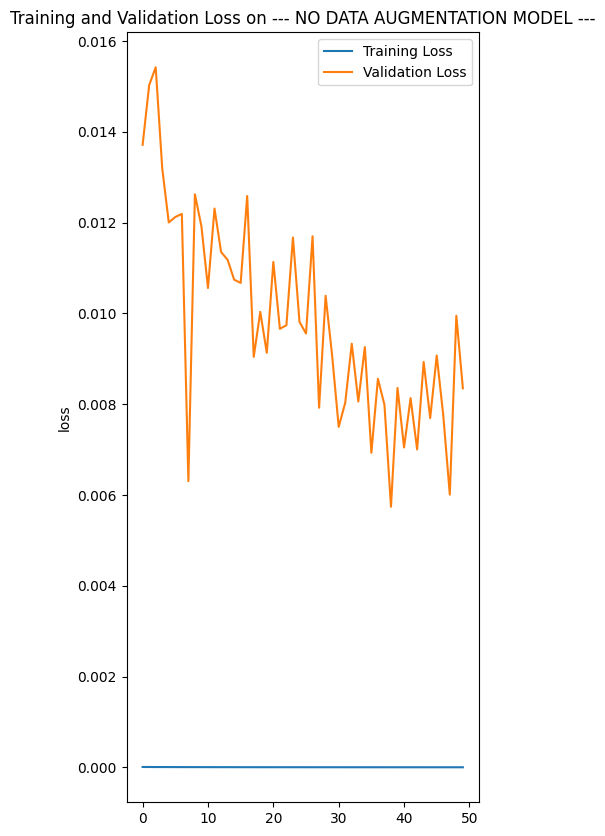

In [171]:
plot_metrics(original_history.history['accuracy'],original_history.history['val_accuracy'],original_history.history['loss'],original_history.history['val_loss'],"--- ORIGINAL MODEL ---")
plot_metrics(model_2_history.history['accuracy'],model_2_history.history['val_accuracy'],model_2_history.history['loss'],model_2_history.history['val_loss'],"--- MODEL 2 ---")
plot_metrics(no_da_history.history['accuracy'],no_da_history.history['val_accuracy'],no_da_history.history['loss'],no_da_history.history['val_loss'],"--- NO DATA AUGMENTATION MODEL ---")

Model number 0
With an accuracy of 100.0%
With an accuracy of 67.81%
With an accuracy of 100.0%
Model number 1
With an accuracy of 100.0%
With an accuracy of 100.0%
With an accuracy of 100.0%
Model number 2
With an accuracy of 100.0%
With an accuracy of 98.8%
With an accuracy of 100.0%


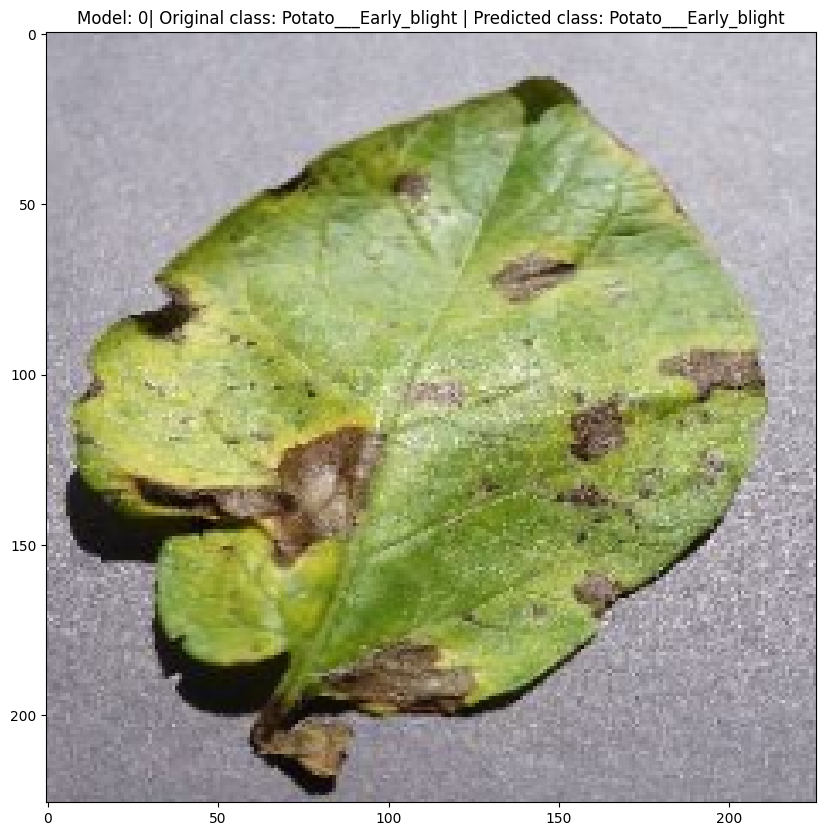

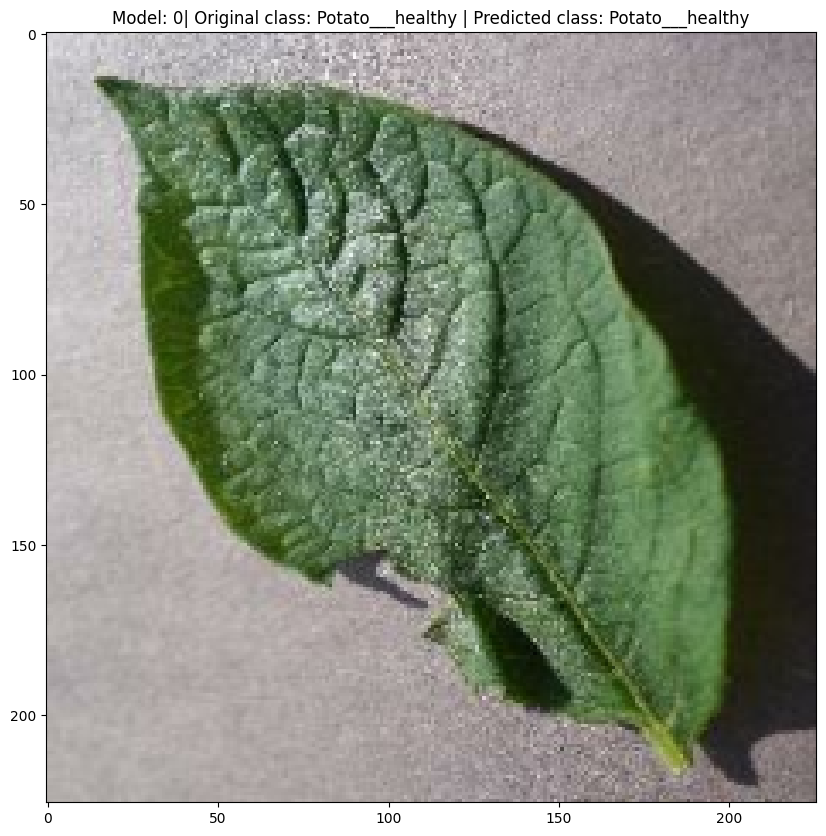

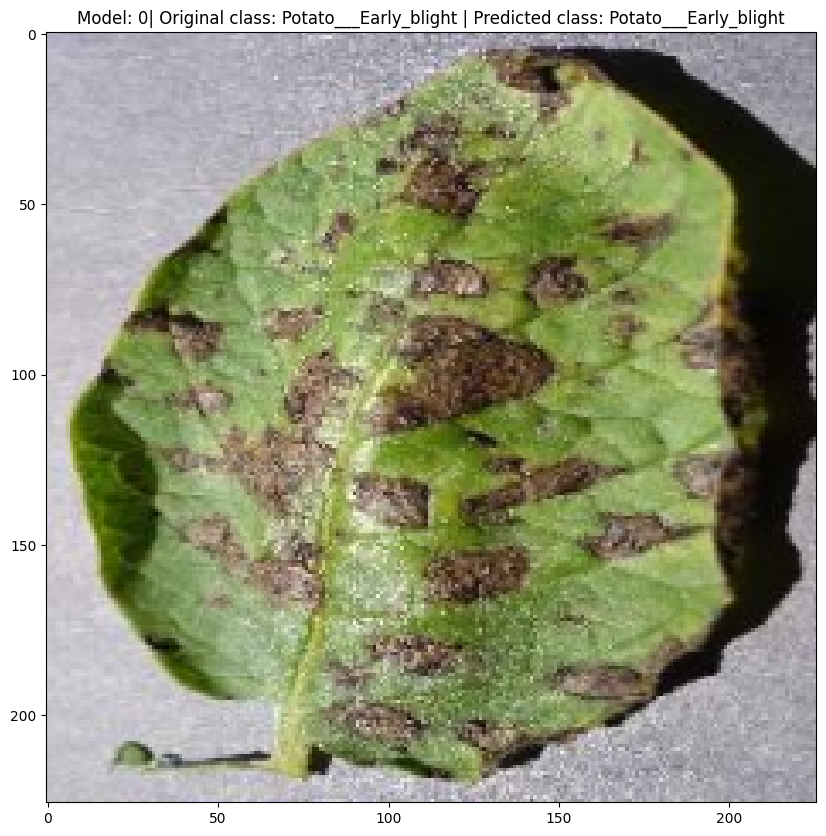

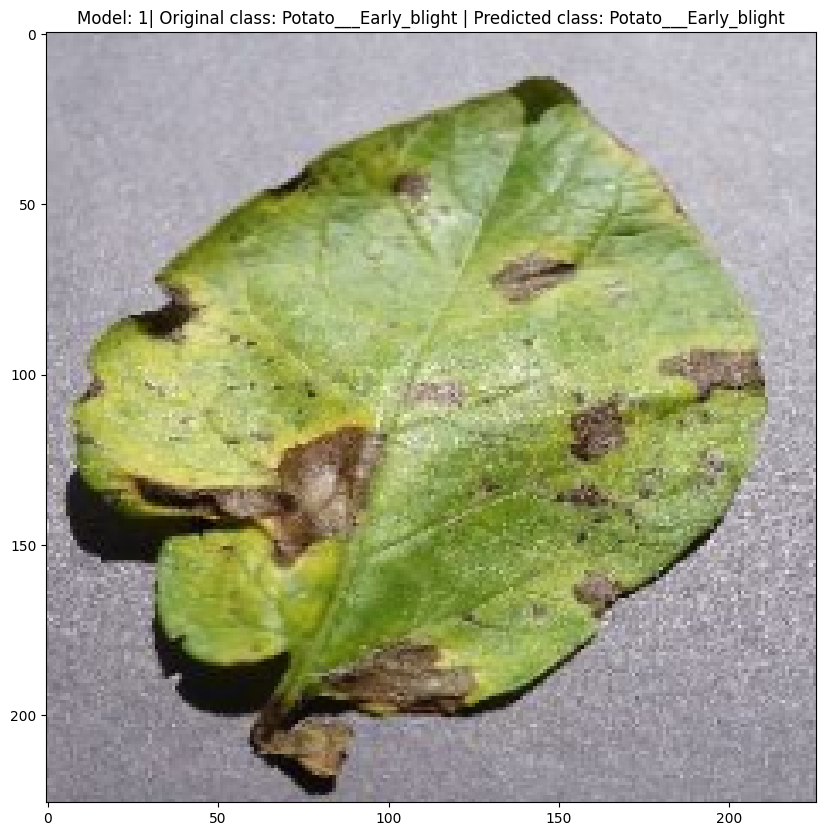

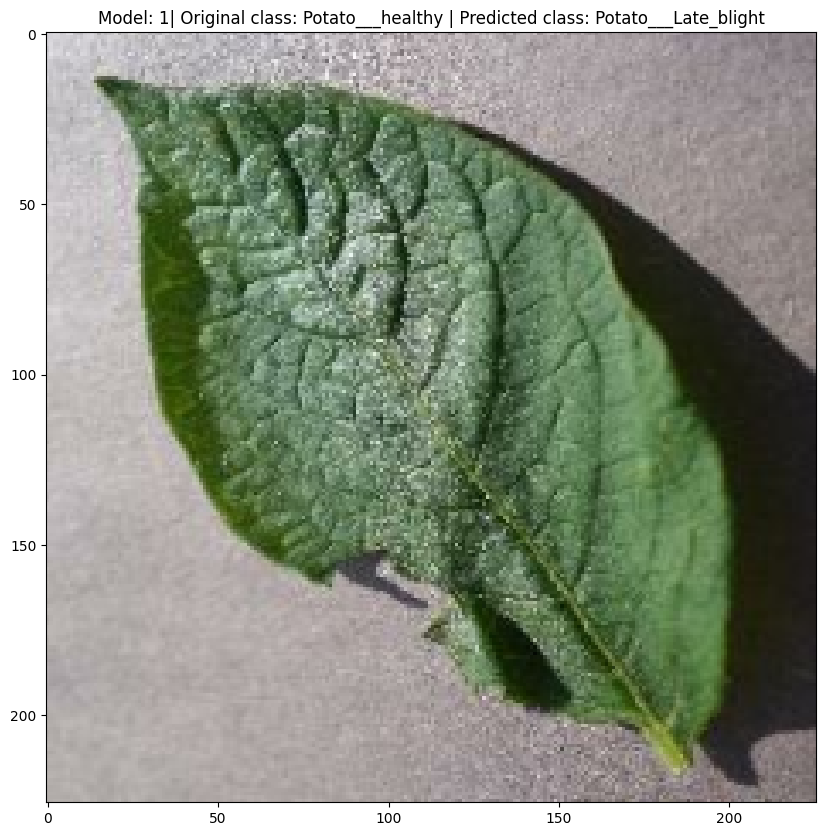

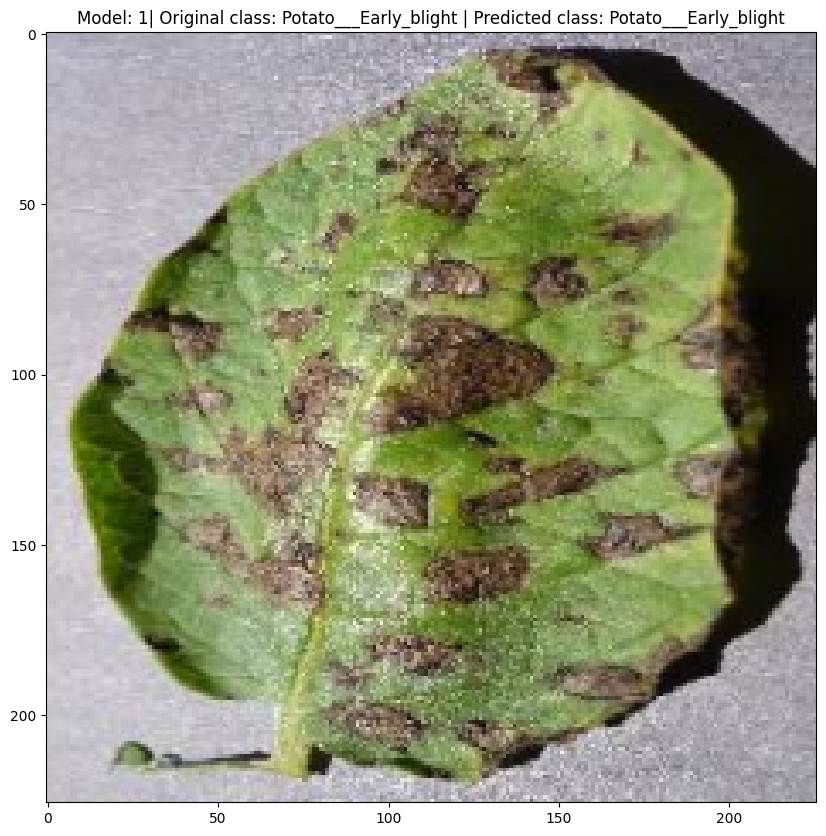

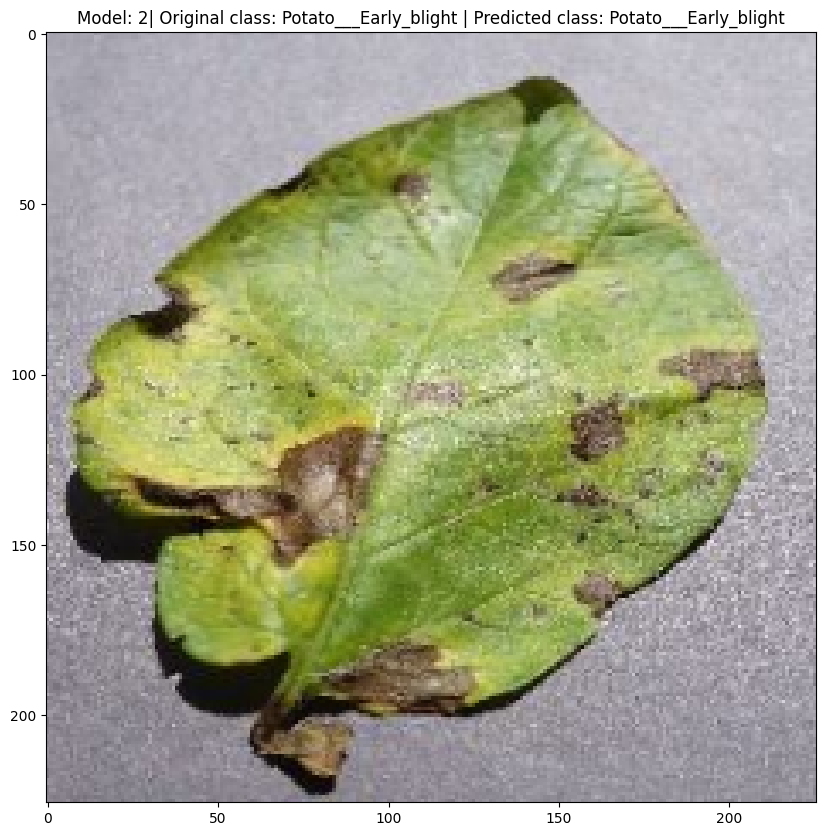

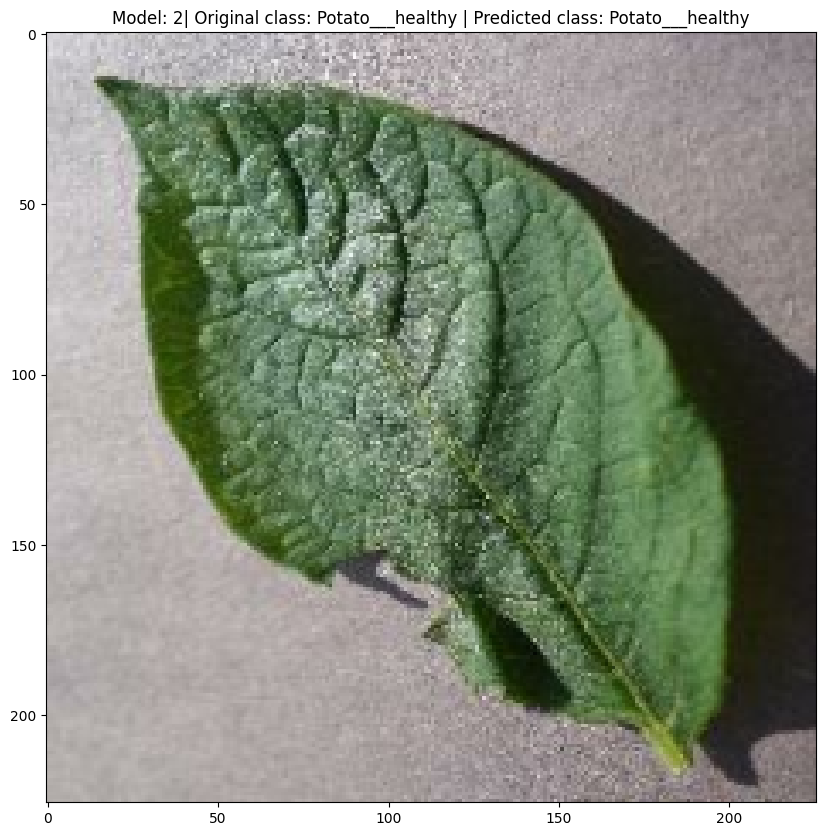

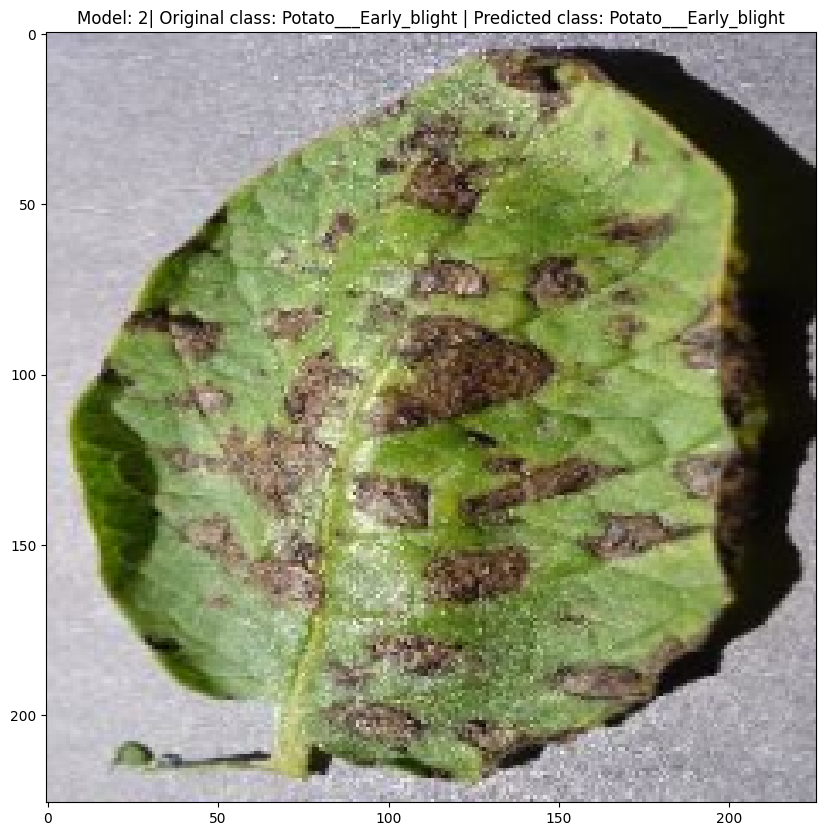

In [168]:
def predict(model,image):
  predictions = model.predict(image,verbose=0)
  return class_names[predictions.argmax()],round(predictions.max()*100,2)

for image_batch,label_batch in test_ds.take(1):
  for model_index,model in enumerate([original_model,no_da_model,model_2]):
    print("Model number",model_index)
    first_three_images = image_batch[:3]
    first_three_labels = label_batch[:3]
    for img_index,image in enumerate(first_three_images):
      prediction = predict(model,image.numpy().reshape(1,IMG_SIZE,IMG_SIZE,CHANNELS))
      plt.figure(figsize=(10, 10))
      plt.imshow(image.numpy().astype("uint8"))
      plt.title(f"Model: {model_index}| Original class: {class_names[first_three_labels[img_index]]} | Predicted class: {prediction[0]}")
      print(f"With an accuracy of {prediction[1]}%")